In [31]:
import numpy as np
import pandas as pd
import tensorflow as tf
##from keras import LSTM
#from keras.layers.core import Dense, Activation, Dropout
#from keras.models import Sequential
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random
import time

In [35]:
df = pd.read_excel(r'C:\all\data\monotonic_pred_force.xlsx')

In [36]:
df=df.set_index(df.index)
df.drop('specimen',axis=1,inplace=True)
print("data shape is ", df.shape)
print("training data size: ", df.shape[0]*0.94)
train_value = int(df.shape[0]*0.94)
print(train_value)
df.head()

data shape is  (143578, 1)
training data size:  134963.31999999998
134963


,Force
0,-0.031789
1,473.515200
2,1127.513000
3,1758.178000
4,2352.635000


In [37]:
df['Force']=df['Force']/100000

open stock prices shape:  (143578, 1)


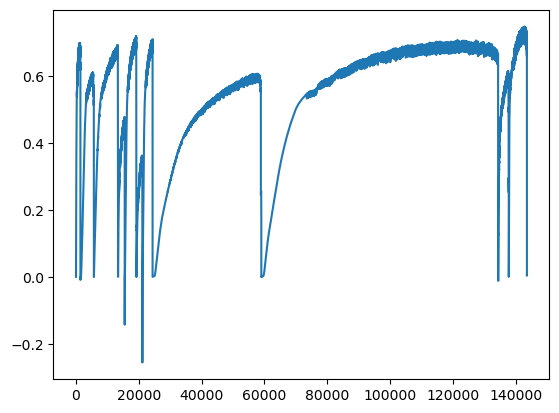

In [38]:
# Open price visualiztion
open_stock_prices = df.Force.values
open_stock_prices = open_stock_prices.reshape(-1, 1)
print("open stock prices shape: ",open_stock_prices.shape)

plt.plot(open_stock_prices)
plt.show()

In [39]:
# Today's forcast value depends on last 20-day values
window_size=200
# Only using "Open" feature for training
train_data=df.iloc[:(train_value+window_size), 0:1]
train_data.shape

(135163, 1)

In [40]:
train_data= np.array(train_data)

In [41]:
# Append window-sized data to training dataset
x_train, y_train = [], []
train_len = len(train_data)
for i in range(train_len-window_size):
    x_train.append(train_data[i:i+window_size])
    y_train.append(train_data[i+window_size])

x_train=np.array(x_train)
y_train=np.array(y_train)
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (134963, 200, 1)
y_train shape:  (134963, 1)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, LayerNormalization


In [43]:


model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
    LayerNormalization(),
   
    LSTM(256, return_sequences=True),

    LSTM(128),

    Dense(1),

])


model.summary()
model.compile(optimizer='adam', loss='mse')

start = time.time()

print ('compilation time : ', time.time() - start)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 200, 512)          1052672   
                                                                 
 layer_normalization_4 (Lay  (None, 200, 512)          1024      
 erNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 200, 256)          787456    
                                                                 
 lstm_14 (LSTM)              (None, 128)               197120    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2038401 (7.78 MB)
Trainable params: 2038401 (7.78 MB)
Non-trainable params: 0 (0.00 Byte)
________________

USE CHEKPOINT NEXT TIME


In [ ]:
model.compile(loss=..., optimizer=...,
              metrics=['accuracy'])

EPOCHS = 10
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model is saved at the end of every epoch, if it's the best seen so far.
model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# The model (that are considered the best) can be loaded as -
keras.models.load_model(checkpoint_filepath)

# Alternatively, one could checkpoint just the model weights as -
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
model.fit(epochs=EPOCHS, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) can be loaded as -
model.load_weights(checkpoint_filepath)

In [44]:
History= model.fit(x_train, y_train, epochs=10, batch_size=512,validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/10
211/211 - 1703s - loss: 0.0479 - val_loss: 0.0025 - 1703s/epoch - 8s/step
Epoch 2/10
211/211 - 1732s - loss: 0.0172 - val_loss: 9.8899e-04 - 1732s/epoch - 8s/step
Epoch 3/10
211/211 - 1748s - loss: 0.0062 - val_loss: 9.7238e-04 - 1748s/epoch - 8s/step
Epoch 4/10
211/211 - 1735s - loss: 0.0077 - val_loss: 0.0021 - 1735s/epoch - 8s/step
Epoch 5/10
211/211 - 1718s - loss: 0.0045 - val_loss: 7.1885e-04 - 1718s/epoch - 8s/step
Epoch 6/10
211/211 - 1714s - loss: 0.0038 - val_loss: 7.7476e-04 - 1714s/epoch - 8s/step
Epoch 7/10
211/211 - 1722s - loss: 0.0025 - val_loss: 4.1720e-04 - 1722s/epoch - 8s/step
Epoch 8/10
211/211 - 1715s - loss: 0.0013 - val_loss: 1.8234e-04 - 1715s/epoch - 8s/step
Epoch 9/10
211/211 - 1714s - loss: 0.0011 - val_loss: 1.4995e-04 - 1714s/epoch - 8s/step
Epoch 10/10
211/211 - 1717s - loss: 7.3648e-04 - val_loss: 8.8300e-05 - 1717s/epoch - 8s/step


In [91]:
model.save(r'C:\all\data/Force_100000.keras')  # The file needs to end with the .keras extension

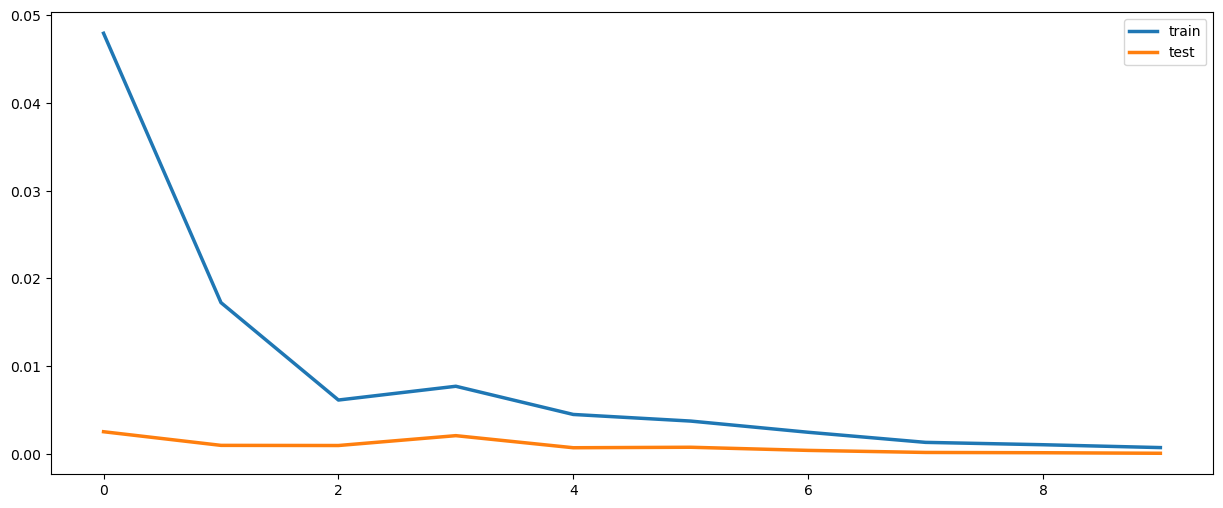

In [45]:
plt.figure(figsize=(15,6))
plt.plot(History.history['loss'], label='train', linewidth = 2.5)
plt.plot(History.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [46]:
train_df = df.iloc[:train_value]
test_df = df.iloc[train_value:]

# axis{0/’index’, 1/’columns’}, default 0 (vertically concatenate).
# The axis to concatenate along.
data = pd.concat((train_df['Force'], test_df['Force']), axis=0)
# Include first window_size (20)data in order to predict first value of test data
test_input = data[len(train_df) - window_size:].values
test_input = test_input.reshape(-1,1)
#test_input = scaler.transform(test_input)
print(type(test_input))

x_test = []

for i in range(window_size, len(test_df)+window_size):
    x_test.append(test_input[i-window_size:i, 0])

x_test = np.array(x_test)
print("Input test data size: ",x_test.shape)

<class 'numpy.ndarray'>
Input test data size:  (8615, 200)


In [47]:
#Transform x_test values compatible with LSTM
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test.shape)

(8615, 200, 1)


In [48]:
prediction = model.predict(x_test)
print("The shape of predicted values of test data before inverse_transform: ",\
      prediction.shape)

270/270 [==============================] - 90s 331ms/step
The shape of predicted values of test data before inverse_transform:  (8615, 1)


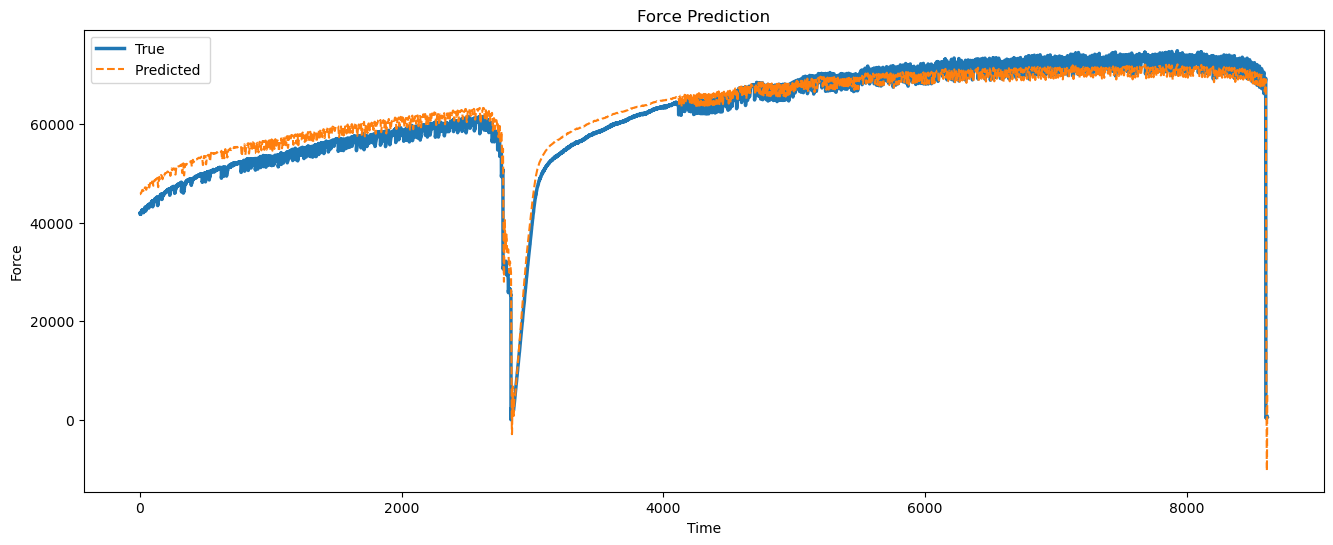

In [52]:
y_test = df.iloc[train_value: ,0:1].values
plt.figure(figsize=(16,6))
plt.plot(y_test*100000,  label='True', linewidth=2.5)
plt.plot(prediction*100000, '--', label='Predicted ')

plt.title('Force Prediction')
plt.xlabel('Time')
plt.ylabel('Force')
plt.legend()
plt.show()

In [54]:
print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction))

Mean Absolute Error:  0.021245910278960577
Mean Squared Error:  0.0007233321040109891


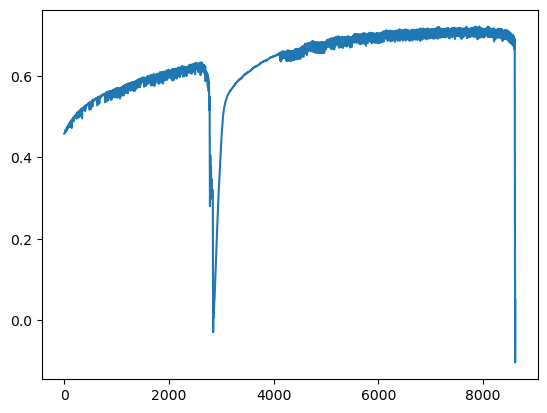

In [55]:
plt.plot(prediction )

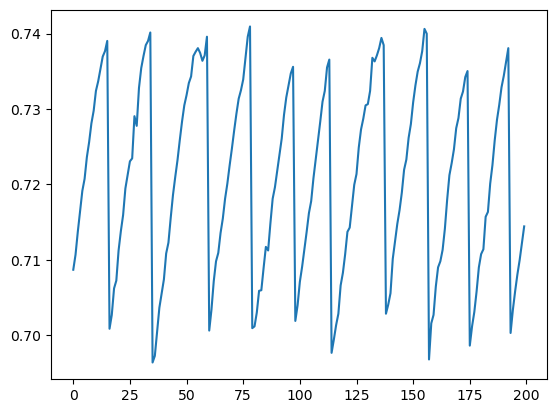

In [56]:
plt.plot(x_test[7000])

In [111]:
predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'Force', timesteps_to_predict = 50, return_future = True)

NameError: name 'predict_future' is not defined

In [84]:
len(x_test)

8615

1/1 [==============================] - 0s 37ms/step


KeyboardInterrupt: 

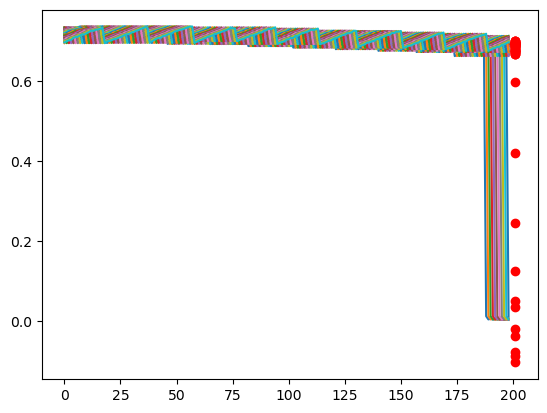

In [88]:
for i in range (1, len(x_test)-1):
    curr_frame = x_test[len(x_test)-i]
    future = []
    
    # Quick plot of the frame we're predicting from
    
    
    points_to_predict = 1
    for i in range(points_to_predict):
          # append the prediction to our empty future list
         future.append(model.predict(curr_frame[newaxis,:,:])[0,0])
          # insert our predicted point to our current frame
         #curr_frame = np.insert(curr_frame, len(x_test[0]), future[-1], axis=0)
          # push the frame up one to make it progress into the future
         curr_frame = curr_frame[1:]
         plt.plot(curr_frame)   
         plt.scatter([201],future, color='red')    

1/1 [==============================] - 0s 46ms/step


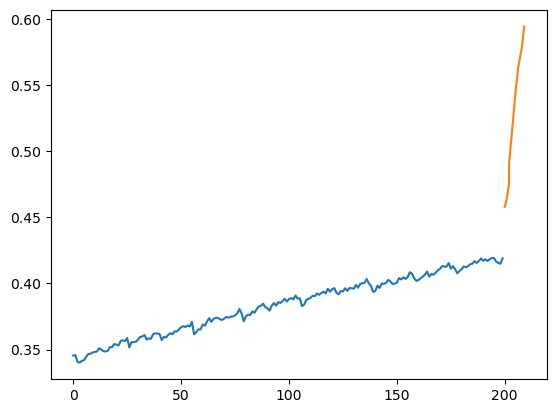

1/1 [==============================] - 0s 66ms/step


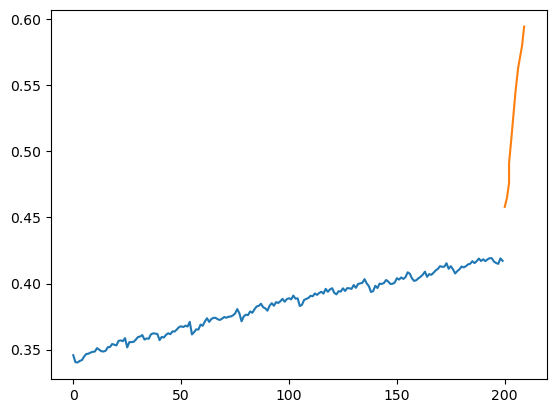

1/1 [==============================] - 0s 55ms/step


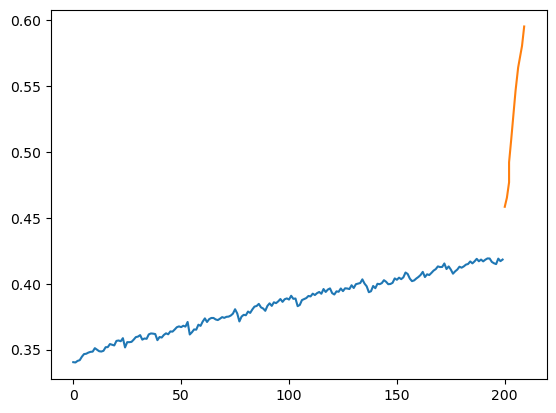

1/1 [==============================] - 0s 67ms/step


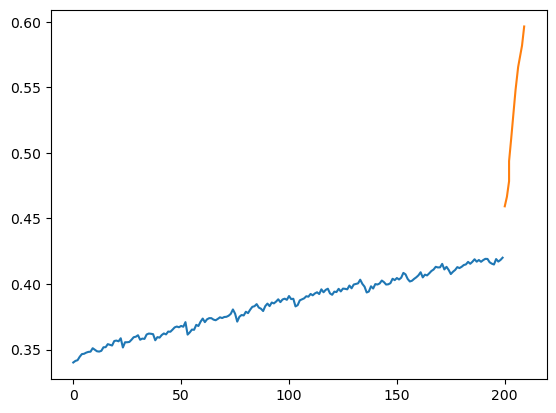

1/1 [==============================] - 0s 67ms/step


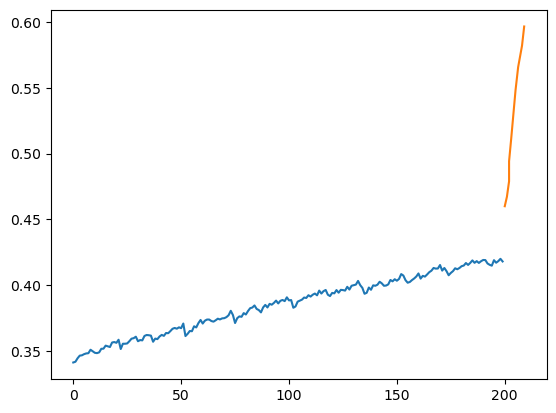

1/1 [==============================] - 0s 67ms/step


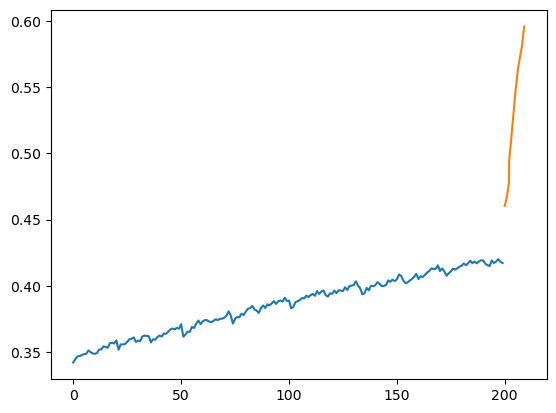

1/1 [==============================] - 0s 61ms/step


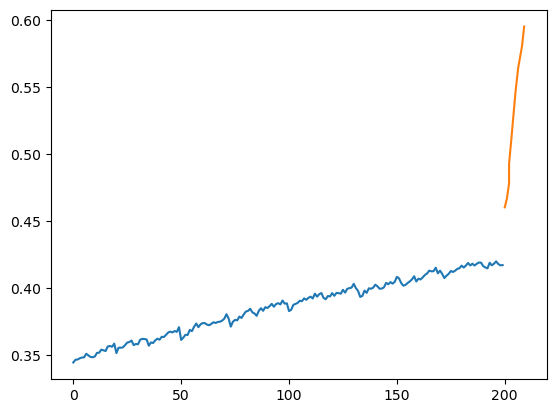

1/1 [==============================] - 0s 71ms/step


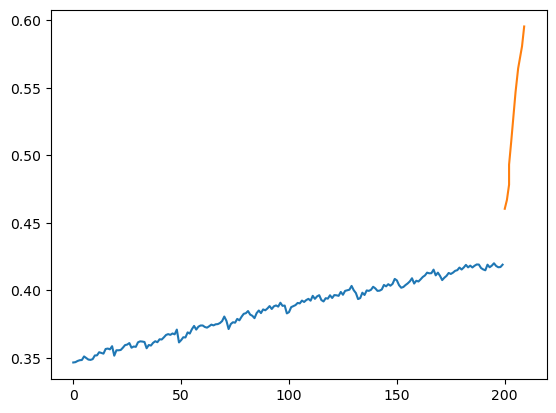

1/1 [==============================] - 0s 81ms/step


KeyboardInterrupt: 

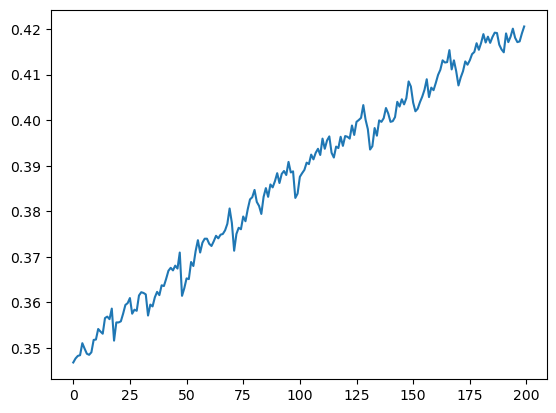

In [128]:
for i in range (1, len(x_test)-1):
    from numpy import newaxis
    # We sorted descending
    curr_frame = x_test[i]
    future = []
    
    # Quick plot of the frame we're predicting from
    plt.plot(curr_frame)
    
    points_to_predict = 10
    for i in range(points_to_predict):
          # append the prediction to our empty future list
         future.append(model.predict(curr_frame[newaxis,:,:])[0,0])
          # insert our predicted point to our current frame
         curr_frame = np.insert(curr_frame, len(x_test[0]), future[-1], axis=0)
          # push the frame up one to make it progress into the future
         curr_frame = curr_frame[1:]
         
    plt.plot([200,201,202,202,203,204,205,206.207,208,209],future)    
        # Display the plot and pause briefly to visualize
    plt.pause(0.5)  # Pauses for 0.5 seconds

# After the loop, keep the final plot on screen
plt.show()


1/1 [==============================] - 0s 57ms/step


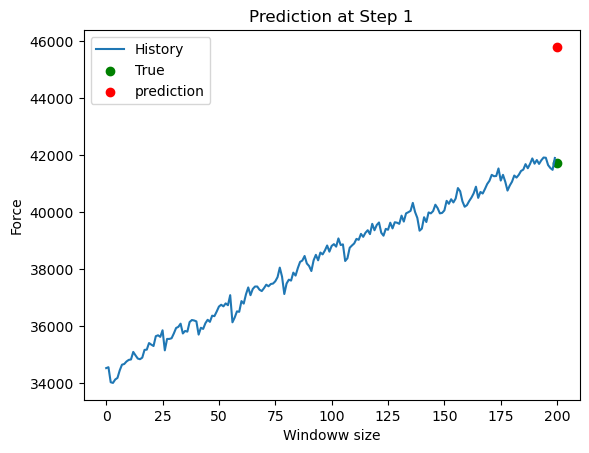

1/1 [==============================] - 0s 67ms/step


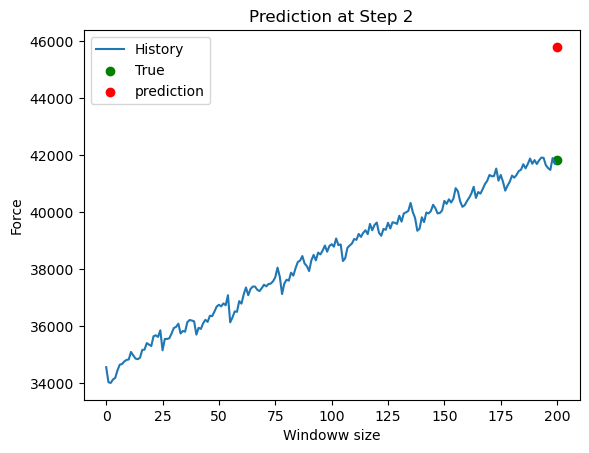

1/1 [==============================] - 0s 67ms/step


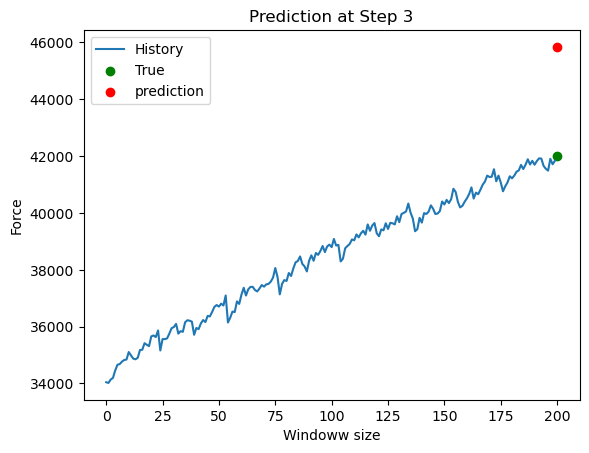

1/1 [==============================] - 0s 83ms/step


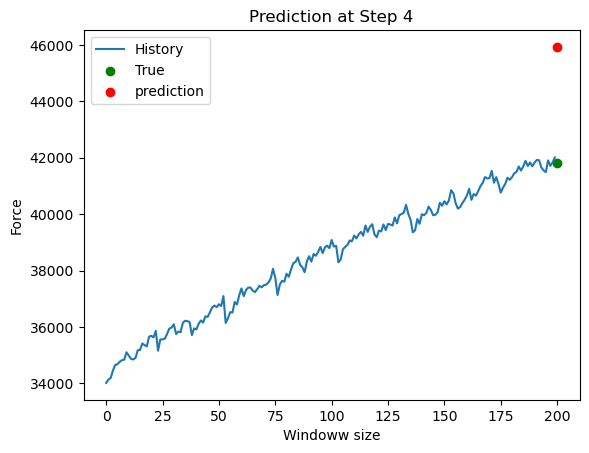

1/1 [==============================] - 0s 87ms/step


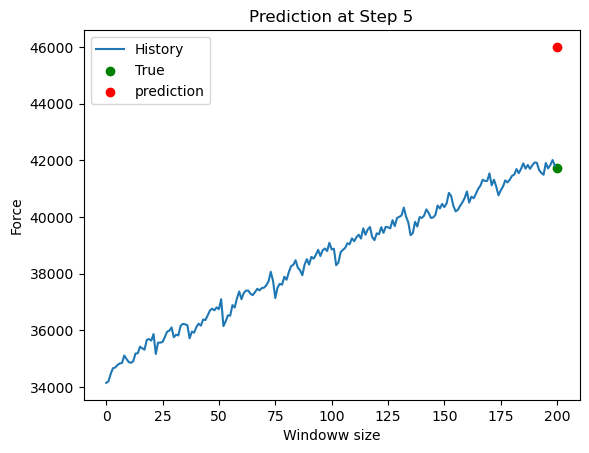

1/1 [==============================] - 0s 83ms/step


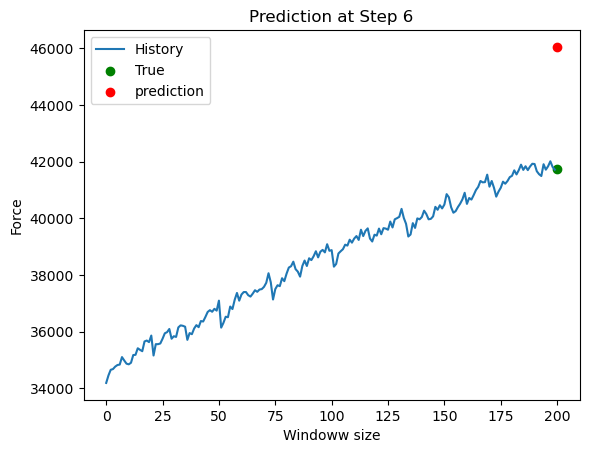

1/1 [==============================] - 0s 80ms/step


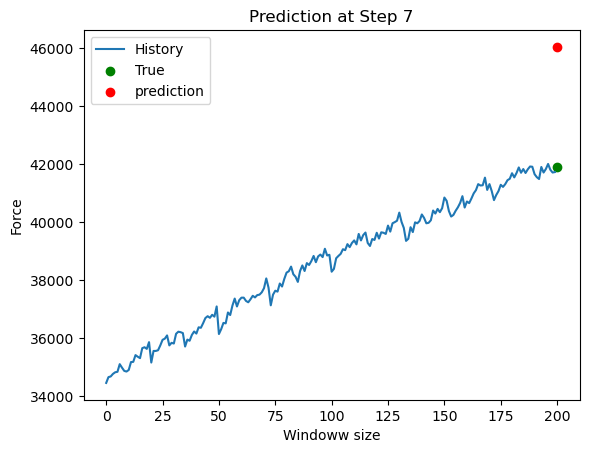

1/1 [==============================] - 0s 67ms/step


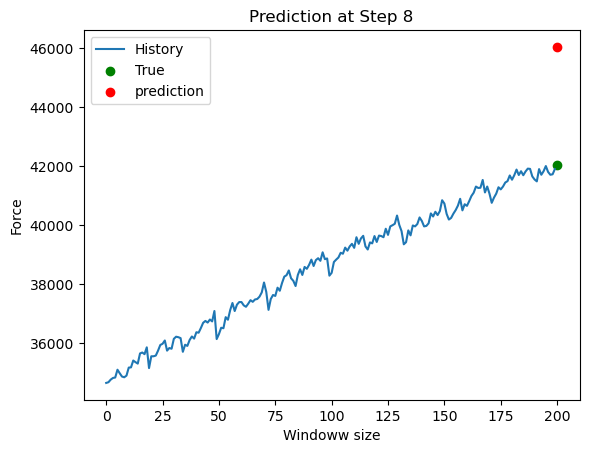

1/1 [==============================] - 0s 69ms/step


KeyboardInterrupt: 

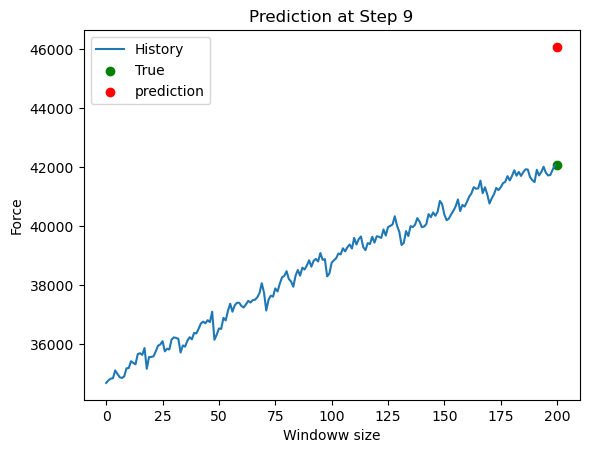

In [140]:

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#              Predicting the future
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for i in range (1, len(x_test)-1):
    from numpy import newaxis
    # We sorted descending
    curr_frame = x_test[i]
    future = []
    
    # Quick plot of the frame we're predicting from
    plt.plot(curr_frame*100000, label='History')
    
    points_to_predict = 1
    for j in range(points_to_predict):
          # append the prediction to our empty future list
         future.append(model.predict(curr_frame[newaxis,:,:])[0,0]*100000)
          # insert our predicted point to our current frame
         curr_frame = np.insert(curr_frame, len(x_test[0]), future[-1], axis=0)
          # push the frame up one to make it progress into the future
         curr_frame = curr_frame[1:]
    plt.scatter([200],x_test[i+1][-1]*100000, label='True',color='green')      
    plt.scatter([200],future, label='prediction',color='red')
    plt.title(f"Prediction at Step {i}")
    plt.xlabel('Window size')
    plt.ylabel('Force')
    plt.legend()
  
        # Display the plot and pause briefly to visualize
    plt.pause(0.5)  # Pauses for 0.5 seconds

# After the loop, keep the final plot on screen
plt.show()


1/1 [==============================] - 0s 68ms/step


ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

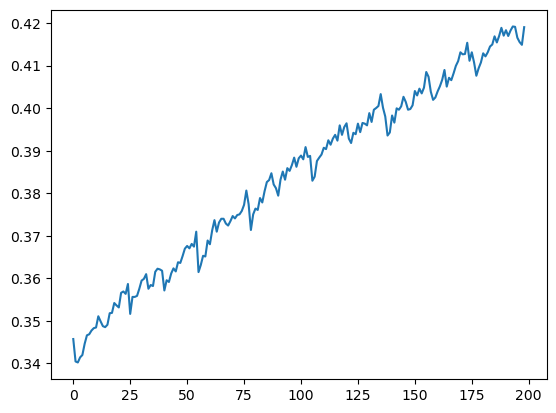

In [124]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(1, len(x_test)-1):
    curr_frame = x_test[i]  # Get the current frame
    future = []  # Initialize future predictions
    
    points_to_predict = 10  # Number of points to predict
    for j in range(points_to_predict):
        # Append the prediction to our empty future list
        future.append(model.predict(curr_frame[np.newaxis, :, :])[0, 0])
        
        # Push the frame up one to make it progress into the future
        curr_frame = curr_frame[1:]

        # Clear the previous plot
        plt.cla()  # or plt.clf() if you want to clear the whole figure

        # Plot the current frame
        plt.plot(curr_frame, label='Current Frame')

        # Plot the predicted future point
        plt.plot([200,201,202,203,204,205,206,207,208,209], future, color='red', label='Predicted Point')

        # Add labels, title, and legend
        plt.title(f'Prediction at Step {i}')
        plt.xlabel('Time Steps')
        plt.ylabel('Values')
        plt.legend()

        # Display the plot and pause briefly to visualize
        plt.pause(0.5)  # Pauses for 0.5 seconds

# After the loop, keep the final plot on screen
plt.show()


In [116]:
predict_future(X_min = X_min, X_max = X_max, numeric_colname = 'Force', timesteps_to_predict = 50, return_future = True)

NameError: name 'X_min' is not defined